✅ Using NumPy with CPU.
Compare to Folpsv1

FOLPSv1 only allowed A_full=False
Loading matrices from matrices_nfftlog128_Afull-False_use_TNS-False.npy


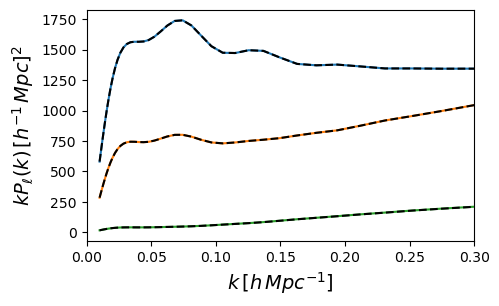

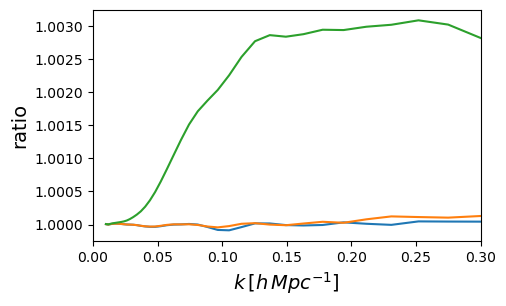

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
sys.path.append('../')
import folps as FOLPS
# !pwd

print('Compare to Folpsv1')
print('')

#CMASS NGC cosmology

#omega_i = Omega_i h² 
omega_b = 0.02242;        #baryons
omega_cdm = 0.117;       #CDM
omega_ncdm = 0.0;    #massive neutrinos 
h = 0.67;                 #h = H0/100
z_pk = 0.57;                 #evaluation redshift
CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]

# omega_b = 0.02242;        #baryons
# omega_cdm = 0.117;       #CDM
# omega_ncdm = 0.0;    #massive neutrinos 
# h = 0.67;                 #h = H0/100
# z_pk = 0.57;                 #evaluation redshift
# CosmoParams = [z_pk, omega_b, omega_cdm, omega_ncdm, h]


kwargs = {'z': z_pk,
          'h': h,
          'Omega_m': (omega_cdm+omega_b+omega_ncdm)/h**2,
          # 'f0': np.float64(0.6880638641959066),  #if not provided, the code computes it
          'fnu': 0.00}

kwargs['Omega_m']




# inputpkT = np.loadtxt('pk_linear_simtocmass.txt', unpack = True)
# # Fallback: read precomputed k, pk from the repository file (do not create a cosmo object)
data_path = 'pk_linear_simtocmass.txt'
k_arr, pk_arr = np.loadtxt(data_path, unpack=True)
classy = {'k': k_arr, 'pk': pk_arr} # Provide k and pk only in Mpc/h units


#bias parameters
b1 = 1.9;                 
b2= 8/21*(b1-1)
bs2= -4/7*(b1-1)      
b3nl = 32/315*(b1 - 1);  

#EFT parameters
alpha0, alpha2, alpha4 = 0,0,0    # PEFT(k) = (alpha0 + alpha2*mu^2+ alpha4*mu^4)  k^2 Plin(k)
ctilde = 0               #NLO counterterm
X_FoG = 0  # uses a Lorentzian Damping 1/(1+x^2), with x = X_FoG f sigma_v mu. 

#Stochatics parameters
# Noise is Pshot = PshotP * ( alphashot0 + alphashot2*(k*mu)**2 )
alphashot0 = 0;          
alphashot2 = 0;            
PshotP = 0    # =1/barn.  Poissonian shot noise
NuisanParams = [b1, b2, bs2, b3nl, alpha0, alpha2, alpha4, ctilde, alphashot0, alphashot2, PshotP,X_FoG]


## AP
Omfid = -1  # for AP set > 0    
qpar, qperp = FOLPS.qpar_qperp(Omega_fid=Omfid, Omega_m=kwargs['Omega_m'], z_pk=kwargs['z'])   
qpar,qperp # gives 1,1 if Omega_fid<=0 or z_pk=0

print('FOLPSv1 only allowed A_full=False')
matrix = FOLPS.MatrixCalculator(A_full=False) 
mmatrices = matrix.get_mmatrices()


# output k_ev
k_ev = np.logspace(np.log10(0.01), np.log10(0.3), num = 40) # array of k_ev in [h/Mpc]


nonlinear = FOLPS.NonLinearPowerSpectrumCalculator(mmatrices=mmatrices,
                                             kernels='fk',
                                             **kwargs)

table, table_nonwiggles = nonlinear.calculate_loop_table(k=classy['k'], pklin=classy['pk'],cosmo=None, **kwargs)

multipoles = FOLPS.RSDMultipolesPowerSpectrumCalculator(model='FOLPSD') 

pkl0, pkl2, pkl4  = multipoles.get_rsd_pkell(kobs=k_ev, qpar=qpar, qper=qperp, pars=NuisanParams,
                                       table=table, table_now=table_nonwiggles,
                                       bias_scheme='folps', damping='lor'
                                       )
kh=k_ev


###Compare to Old FOLPS
loaded_data = np.load('F_folpsv1_pkloop.npy')
kl=loaded_data[0] 
P0=loaded_data[1] 
P2=loaded_data[2] 
P4=loaded_data[3] 

fig, axs = plt.subplots(figsize=(5,3))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'$k P_{\ell}(k) \, [h^{-1} \,  Mpc]^2$', fontsize =  14)

axs.plot(kh, kh * pkl0, label=r'$\ell = 0$')
axs.plot(kl, kl * P0, label=r'$\ell = 0$',ls='--',color='k')
axs.plot(kh, kh * pkl2, label=r'$\ell = 2$')
axs.plot(kl, kl * P2, label=r'$\ell = 0$',ls='--',color='k')
axs.plot(kh, kh * pkl4, label=r'$\ell = 4$')
axs.plot(kl, kl * P4, label=r'$\ell = 0$',ls='--',color='k')

axs.set_xlim([0, 0.3])
plt.show()


fig, axs = plt.subplots(figsize=(5,3))
axs.set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  14)
axs.set_ylabel(r'ratio', fontsize =  14)

axs.plot(kh, pkl0/P0, label=r'$\ell = 0$')
axs.plot(kh, pkl2/P2, label=r'$\ell = 2$')
axs.plot(kh, pkl4/P4, label=r'$\ell = 4$')


axs.set_xlim([0, 0.3])
plt.show()